# Procesamiento de lenguaje natural
## Desafío 3

## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import os
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

2024-06-06 23:49:36.602927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 23:49:36.709248: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-06 23:49:37.113686: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jorge/miniconda3/envs/tensorflow/lib/:/home/jorge/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorrt/
2024-06-06 23:49:37.113761: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

### Datos

Emplearé el libro "El señor de los anillos" preprocesado previamente.

Cada linea del archivo es una oración. Esta elección es para mejorar la generación de nuevas secuencias a través del contexto de una oración completa.

In [2]:
# Defino la ruta del archivo
file_path = os.path.join('libros_dataset', 'el_senor_de_los_anillos_procesado_oraciones.txt')


In [3]:
# Leer el contenido del archivo
with open(file_path, 'r', encoding='utf-8') as file:
    file_content = file.read()

In [4]:
# Pasar todo el texto a minúscula
article_text = file_content.lower()

In [5]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

'tolkien, jrr.\nel señor de los anillos.\nla comunidad del anillo.\nprologo.\nde los hobbits.\neste libro trata principalmente de los hobbits, y el lector descubrirá en sus páginas mucho del carácter y algo de la historia de este pueblo.\npodrá encontrarse más información en los extractos del libro rojo de la frontera del oeste que ya han sido publicados con el título de el hobbit.\nel relato tuvo su origen en los primeros capítulos del libro rojo, compuesto por bilbo bolsón -el primer hobbit que fue famoso en el mundo entero - y que él tituló historia de una ida y de una vuelta, pues contaba el viaje de bilbo hacia el este y la vuelta, aventura que más tarde enredaría a todos los hobbits en los importantes acontecimientos que aquí se relatan.\nno obstante, muchos querrán saber desde un principio algo más de este pueblo notable y quizás algunos no tengan el libro anterior.\npara esos lectores se han reunido aquí algunas notas sobre los puntos más importantes de la tradición hobbit, y s

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [6]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [7]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [8]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [9]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

63

In [10]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [11]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [12]:
tokenized_text[:1000]

[6,
 3,
 57,
 25,
 44,
 50,
 1,
 48,
 8,
 49,
 40,
 40,
 11,
 41,
 50,
 57,
 8,
 32,
 50,
 7,
 3,
 40,
 8,
 51,
 50,
 8,
 57,
 3,
 32,
 8,
 61,
 1,
 44,
 57,
 57,
 3,
 32,
 11,
 41,
 57,
 61,
 8,
 31,
 3,
 29,
 62,
 1,
 44,
 51,
 61,
 51,
 8,
 51,
 50,
 57,
 8,
 61,
 1,
 44,
 57,
 57,
 3,
 11,
 41,
 24,
 40,
 3,
 57,
 3,
 54,
 3,
 11,
 41,
 51,
 50,
 8,
 57,
 3,
 32,
 8,
 55,
 3,
 15,
 15,
 44,
 6,
 32,
 11,
 41,
 50,
 32,
 6,
 50,
 8,
 57,
 44,
 15,
 40,
 3,
 8,
 6,
 40,
 61,
 6,
 61,
 8,
 24,
 40,
 44,
 1,
 31,
 44,
 24,
 61,
 57,
 29,
 50,
 1,
 6,
 50,
 8,
 51,
 50,
 8,
 57,
 3,
 32,
 8,
 55,
 3,
 15,
 15,
 44,
 6,
 32,
 48,
 8,
 34,
 8,
 50,
 57,
 8,
 57,
 50,
 31,
 6,
 3,
 40,
 8,
 51,
 50,
 32,
 31,
 62,
 15,
 40,
 44,
 40,
 36,
 8,
 50,
 1,
 8,
 32,
 62,
 32,
 8,
 24,
 36,
 54,
 44,
 1,
 61,
 32,
 8,
 29,
 62,
 31,
 55,
 3,
 8,
 51,
 50,
 57,
 8,
 31,
 61,
 40,
 36,
 31,
 6,
 50,
 40,
 8,
 34,
 8,
 61,
 57,
 54,
 3,
 8,
 51,
 50,
 8,
 57,
 61,
 8,
 55,
 44,
 32,
 6,
 3,
 40,
 44

### Organizando y estructurando el dataset

In [13]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [14]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [15]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [16]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [17]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [18]:
X.shape

(483152, 100)

In [19]:
X[0,:10]

array([ 6,  3, 57, 25, 44, 50,  1, 48,  8, 49])

In [20]:
y[0,:10]

array([ 3, 57, 25, 44, 50,  1, 48,  8, 49, 40])

In [21]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

In [22]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [23]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 63)         0         
 ibuted)                                                         
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 200)         52800     
                                                                 
 dense (Dense)               (None, None, 63)          12663     
                                                                 
Total params: 65,463
Trainable params: 65,463
Non-trainable params: 0
_________________________________________________________________


2024-06-06 23:49:41.428387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-06 23:49:41.436024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-06 23:49:41.436238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-06 23:49:41.436743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags


### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [24]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model_char")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [25]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20
   3/1888 [..............................] - ETA: 1:54 - loss: 3.8834

2024-06-06 23:49:44.516097: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1887/1888 [============================>.] - ETA: 0s - loss: 2.0271

2024-06-06 23:52:11.208743: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3583692000 exceeds 10% of free system memory.



 mean perplexity: 5.058195365534271 

INFO:tensorflow:Assets written to: my_model_char/assets
Saved new model!
1888/1888 [==============================] - 151s 79ms/step - loss: 2.0270
Epoch 2/20
1888/1888 [==============================] - ETA: 0s - loss: 1.7379

2024-06-06 23:54:48.726553: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3583692000 exceeds 10% of free system memory.



 mean perplexity: 4.570612076830947 

INFO:tensorflow:Assets written to: my_model_char/assets
Saved new model!
1888/1888 [==============================] - 158s 84ms/step - loss: 1.7379
Epoch 3/20
1887/1888 [============================>.] - ETA: 0s - loss: 1.6840

2024-06-06 23:57:09.679982: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3583692000 exceeds 10% of free system memory.



 mean perplexity: 4.463606457296127 

INFO:tensorflow:Assets written to: my_model_char/assets
Saved new model!
1888/1888 [==============================] - 141s 74ms/step - loss: 1.6840
Epoch 4/20
1888/1888 [==============================] - ETA: 0s - loss: 1.6609

2024-06-06 23:59:41.038486: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3583692000 exceeds 10% of free system memory.



 mean perplexity: 4.419148207488857 

INFO:tensorflow:Assets written to: my_model_char/assets
Saved new model!
1888/1888 [==============================] - 151s 80ms/step - loss: 1.6609
Epoch 5/20
1888/1888 [==============================] - ETA: 0s - loss: 1.6467

2024-06-07 00:02:16.543461: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3583692000 exceeds 10% of free system memory.



 mean perplexity: 4.368722676071632 

INFO:tensorflow:Assets written to: my_model_char/assets
Saved new model!
1888/1888 [==============================] - 156s 82ms/step - loss: 1.6467
Epoch 6/20
1888/1888 [==============================] - ETA: 0s - loss: 1.6373
 mean perplexity: 4.362087953232964 

INFO:tensorflow:Assets written to: my_model_char/assets
Saved new model!
1888/1888 [==============================] - 150s 80ms/step - loss: 1.6373
Epoch 7/20
1888/1888 [==============================] - ETA: 0s - loss: 1.6305
 mean perplexity: 4.3647389637322815 

1888/1888 [==============================] - 152s 80ms/step - loss: 1.6305
Epoch 8/20
1888/1888 [==============================] - ETA: 0s - loss: 1.6251
 mean perplexity: 4.350387962206919 

INFO:tensorflow:Assets written to: my_model_char/assets
Saved new model!
1888/1888 [==============================] - 150s 80ms/step - loss: 1.6251
Epoch 9/20
1888/1888 [==============================] - ETA: 0s - loss: 1.6209
 mean perpl

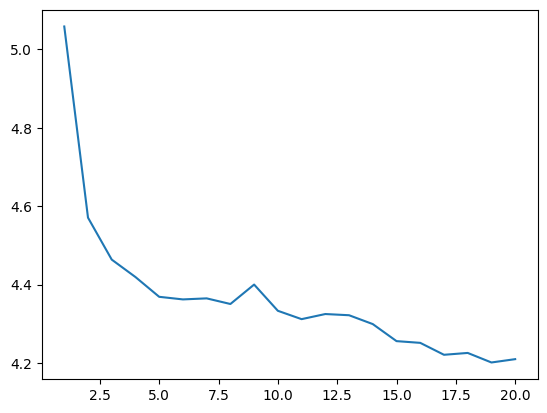

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [27]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model_char')


### Predicción del próximo caracter

In [29]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

#!pip install -q gradio


In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

### Generación de secuencias

In [30]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [31]:
input_text='erase una vez'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'erase una vez más allá de la comarca de la '

###  Beam search y muestreo aleatorio

In [32]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [33]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [34]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="erase una vez")

In [35]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, 50, 40, 61, 32, 50,  8, 62,  1, 61,  8, 28, 50, 35,  8, 26,
       62, 50,  8, 57,  3, 32,  8, 55,  3, 15, 15, 44,  6, 32,  8, 51, 50,
        8])

In [36]:
# veamos las salidas
decode(salidas[0])

':::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::erase una vez que los hobbits de '